In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Boston") \
    .getOrCreate()


### 📦 Conteúdo

#### 🔹 Features (variáveis explicativas)

- **RM**: número médio de quartos por habitação  
- **LSTAT**: porcentagem da população considerada de status inferior  
- **PTRATIO**: relação aluno-professor por município  

#### 🎯 Target (variável resposta)

- **MEDV**: valor médio de casas ocupadas pelos proprietários (em milhares de dólares)


In [2]:
dados = spark.read.csv("boston.csv", header=True, inferSchema=True)
dados.show(5)

+-----+-----+-------+--------+
|   RM|LSTAT|PTRATIO|    MEDV|
+-----+-----+-------+--------+
|6.575| 4.98|   15.3|504000.0|
|6.421| 9.14|   17.8|453600.0|
|7.185| 4.03|   17.8|728700.0|
|6.998| 2.94|   18.7|701400.0|
|7.147| 5.33|   18.7|760200.0|
+-----+-----+-------+--------+
only showing top 5 rows



In [3]:
dados.describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|                RM|             LSTAT|          PTRATIO|             MEDV|
+-------+------------------+------------------+-----------------+-----------------+
|  count|               489|               489|              489|              489|
|   mean| 6.240288343558291|12.939631901840492|18.51656441717792|454342.9447852761|
| stddev|0.6436497627572434|7.0819897890651315|2.111267502630993|165340.2776526678|
|    min|             3.561|              1.98|             12.6|         105000.0|
|    max|             8.398|             37.97|             22.0|        1024800.0|
+-------+------------------+------------------+-----------------+-----------------+



In [5]:
from pyspark.sql.functions import col, sum as spark_sum
dados.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in dados.columns]).show()

+---+-----+-------+----+
| RM|LSTAT|PTRATIO|MEDV|
+---+-----+-------+----+
|  0|    0|      0|   0|
+---+-----+-------+----+



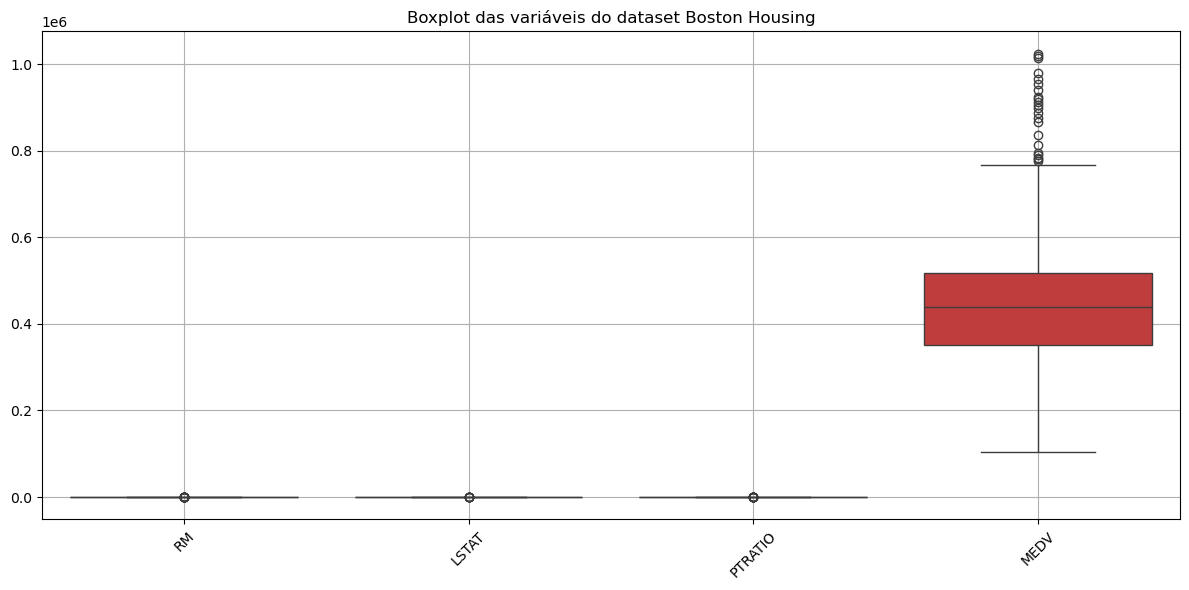

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Limita o número de registros se necessário (caso esteja muito grande)
dados_pd = dados.toPandas()

# 📊 Boxplot de todas as variáveis numéricas
plt.figure(figsize=(12, 6))
sns.boxplot(data=dados_pd)
plt.title("Boxplot das variáveis do dataset Boston Housing")
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

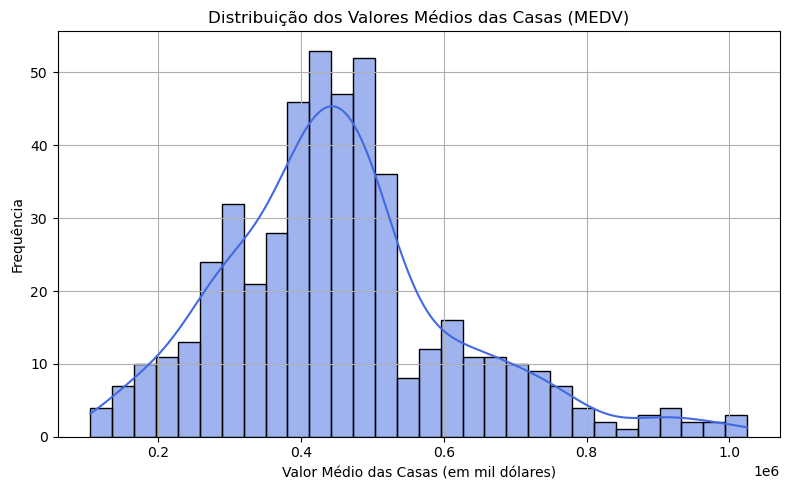

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(data=dados_pd, x="MEDV", bins=30, kde=True, color="royalblue")
plt.title("Distribuição dos Valores Médios das Casas (MEDV)")
plt.xlabel("Valor Médio das Casas (em mil dólares)")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()

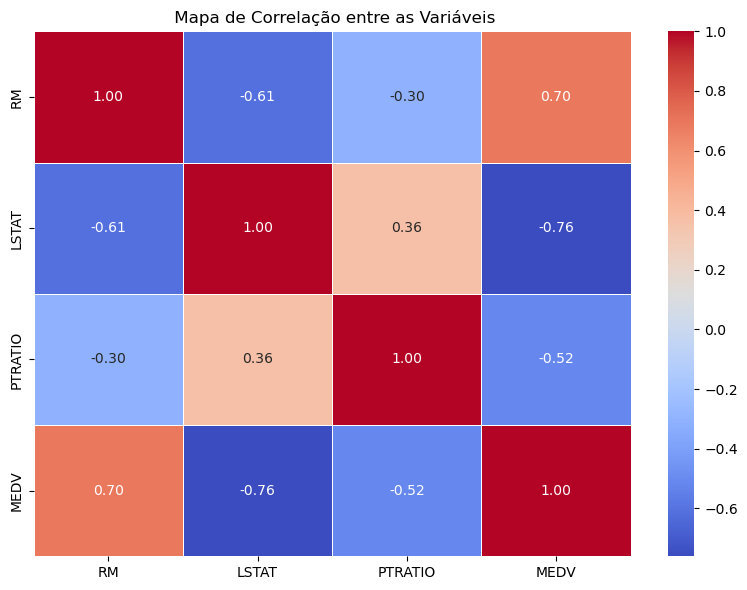

In [8]:
# 🔥 Heatmap de correlação entre as variáveis
import matplotlib.pyplot as plt
import seaborn as sns

# Converter para Pandas (se ainda não feito)
dados_pd = dados.toPandas()

# Calcular correlação
correlacao = dados_pd.corr()

# Plotar heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlacao, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(" Mapa de Correlação entre as Variáveis")
plt.tight_layout()
plt.show()


In [11]:
colunas_utilizadas = ["RM", "LSTAT", "MEDV"]
dados_filtrado = dados.select(colunas_utilizadas)
dados_filtrado.show(5)

+-----+-----+--------+
|   RM|LSTAT|    MEDV|
+-----+-----+--------+
|6.575| 4.98|504000.0|
|6.421| 9.14|453600.0|
|7.185| 4.03|728700.0|
|6.998| 2.94|701400.0|
|7.147| 5.33|760200.0|
+-----+-----+--------+
only showing top 5 rows



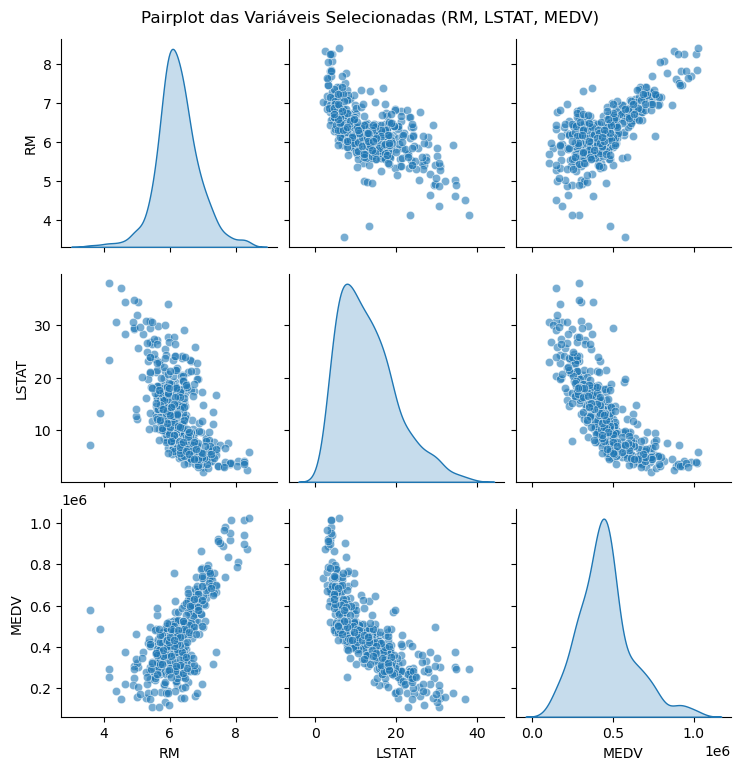

In [12]:
# 🔗 Converter para Pandas para visualização
dados_plot = dados_filtrado.toPandas()

# 📊 Pairplot com seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(dados_plot, diag_kind="kde", plot_kws={"alpha": 0.6})
plt.suptitle("Pairplot das Variáveis Selecionadas (RM, LSTAT, MEDV)", y=1.02)
plt.show()

In [13]:
dados_treino, dados_teste = dados_filtrado.randomSplit([0.8,0.2], seed=42)

In [15]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["RM", "LSTAT"], outputCol= "features")
dados_treino_vet = assembler.transform(dados_treino).select("features", "MEDV")
dados_teste_vet = assembler.transform(dados_teste).select("features", "MEDV")
                            

In [16]:
dados_treino_vet.show(2)

+-------------+--------+
|     features|    MEDV|
+-------------+--------+
| [3.561,7.12]|577500.0|
|[3.863,13.33]|485100.0|
+-------------+--------+
only showing top 2 rows



In [17]:
dados_teste_vet.show(2)

+-------------+--------+
|     features|    MEDV|
+-------------+--------+
|[4.138,23.34]|249900.0|
|[4.628,34.37]|375900.0|
+-------------+--------+
only showing top 2 rows



In [19]:
from pyspark.ml.regression import LinearRegression
rl = LinearRegression(featuresCol="features", labelCol="MEDV")


In [20]:
modelo_treinado = rl.fit(dados_treino_vet)

In [21]:
previsoes = modelo_treinado.transform(dados_teste_vet)

In [22]:
previsoes.select("MEDV", "prediction").show(5)

+--------+------------------+
|    MEDV|        prediction|
+--------+------------------+
|249900.0|138144.20065145794|
|375900.0|43012.398955717406|
|214200.0|112068.34713699369|
|338100.0| 345354.2017980757|
|342300.0|268159.73649454303|
+--------+------------------+
only showing top 5 rows



In [23]:
from pyspark.ml.evaluation import RegressionEvaluator


In [24]:
avaliador_rmse = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="rmse")
avaliador_r2 = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="r2")

In [25]:
rmse = avaliador_rmse.evaluate(previsoes)
r2 = avaliador_r2.evaluate(previsoes)

print(f"❌ Erro Quadrático Médio (RMSE): {rmse:.2f}")
print(f"🎯 Coeficiente de Determinação (R²): {r2:.4f}")

❌ Erro Quadrático Médio (RMSE): 114126.23
🎯 Coeficiente de Determinação (R²): 0.6730


In [26]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="MEDV", numTrees=60, maxDepth=10, seed=42)
modelo_rf = rf.fit(dados_treino_vet)

In [27]:
previsoes_rf = modelo_rf.transform(dados_teste_vet)

In [28]:
previsoes_rf.select("MEDV", "prediction").show(5)

+--------+------------------+
|    MEDV|        prediction|
+--------+------------------+
|249900.0| 295730.0456286751|
|375900.0|236048.59500834133|
|214200.0|236048.59500834133|
|338100.0|409043.30377873767|
|342300.0|249649.31923076924|
+--------+------------------+
only showing top 5 rows



In [29]:
avaliador_rmse_rf = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="rmse")
avaliador_r2_rf = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="r2")

In [30]:
rmse_rf = avaliador_rmse.evaluate(previsoes_rf)
r2_rf = avaliador_r2.evaluate(previsoes_rf)



In [33]:
print(f"❌ Erro Quadrático Médio (RMSE) Regressao Linear: {rmse:.2f}")
print(f"❌ Erro Quadrático Médio (RMSE) Random Forest: {rmse_rf:.2f}")

print("==============")
print(f"🎯 Coeficiente de Determinação (R²)  Regressao Linear:: {r2:.4f}")
print(f"🎯 Coeficiente de Determinação (R²)  RandomForest: {r2_rf:.4f}")

❌ Erro Quadrático Médio (RMSE) Regressao Linear: 114126.23
❌ Erro Quadrático Médio (RMSE) Random Forest: 78198.66
🎯 Coeficiente de Determinação (R²)  Regressao Linear:: 0.6730
🎯 Coeficiente de Determinação (R²)  RandomForest: 0.8465


In [59]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="MEDV", maxIter=200, maxDepth=3)

In [60]:
modelo_gbt = gbt.fit(dados_treino_vet)

In [61]:
previsoes_gbt = modelo_gbt.transform(dados_teste_vet)

In [62]:
previsoes_gbt.select("MEDV", "prediction").show(5)

+--------+------------------+
|    MEDV|        prediction|
+--------+------------------+
|249900.0|365618.04172977153|
|375900.0|226730.22334438088|
|214200.0|226730.22334438088|
|338100.0|437556.66575551697|
|342300.0|197859.93988530547|
+--------+------------------+
only showing top 5 rows



In [63]:
avaliador_rmse_gbt = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="rmse")
avaliador_r2_gbt = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="r2")

In [64]:
rmse_gbt = avaliador_rmse.evaluate(previsoes_gbt)
r2_gbt = avaliador_r2.evaluate(previsoes_gbt)

In [51]:
print(f"❌ Erro Quadrático Médio (RMSE) Regressao Linear: {rmse:.2f}")
print(f"❌ Erro Quadrático Médio (RMSE) Random Forest: {rmse_rf:.2f}")
print(f"❌ Erro Quadrático Médio (RMSE) Gradient Boost Tree: {rmse_gbt:.2f}")


print("==============")
print(f"🎯 Coeficiente de Determinação (R²)  Regressao Linear:: {r2:.4f}")
print(f"🎯 Coeficiente de Determinação (R²)  RandomForest: {r2_rf:.4f}")
print(f"🎯 Coeficiente de Determinação (R²)  Gradient Boost Tree: {r2_gbt:.4f}")

❌ Erro Quadrático Médio (RMSE) Regressao Linear: 114126.23
❌ Erro Quadrático Médio (RMSE) Random Forest: 78198.66
❌ Erro Quadrático Médio (RMSE) Gradient Boost Tree: 99270.91
🎯 Coeficiente de Determinação (R²)  Regressao Linear:: 0.6730
🎯 Coeficiente de Determinação (R²)  RandomForest: 0.8465
🎯 Coeficiente de Determinação (R²)  Gradient Boost Tree: 0.7526


In [58]:
print(f"❌ Erro Quadrático Médio (RMSE) Regressao Linear: {rmse:.2f}")
print(f"❌ Erro Quadrático Médio (RMSE) Random Forest: {rmse_rf:.2f}")
print(f"❌ Erro Quadrático Médio (RMSE) Gradient Boost Tree: {rmse_gbt:.2f}")


print("==============")
print(f"🎯 Coeficiente de Determinação (R²)  Regressao Linear:: {r2:.4f}")
print(f"🎯 Coeficiente de Determinação (R²)  RandomForest: {r2_rf:.4f}")
print(f"🎯 Coeficiente de Determinação (R²)  Gradient Boost Tree: {r2_gbt:.4f}")

❌ Erro Quadrático Médio (RMSE) Regressao Linear: 114126.23
❌ Erro Quadrático Médio (RMSE) Random Forest: 78198.66
❌ Erro Quadrático Médio (RMSE) Gradient Boost Tree: 85544.57
🎯 Coeficiente de Determinação (R²)  Regressao Linear:: 0.6730
🎯 Coeficiente de Determinação (R²)  RandomForest: 0.8465
🎯 Coeficiente de Determinação (R²)  Gradient Boost Tree: 0.8163


In [65]:
print(f"❌ Erro Quadrático Médio (RMSE) Regressao Linear: {rmse:.2f}")
print(f"❌ Erro Quadrático Médio (RMSE) Random Forest: {rmse_rf:.2f}")
print(f"❌ Erro Quadrático Médio (RMSE) Gradient Boost Tree: {rmse_gbt:.2f}")


print("==============")
print(f"🎯 Coeficiente de Determinação (R²)  Regressao Linear:: {r2:.4f}")
print(f"🎯 Coeficiente de Determinação (R²)  RandomForest: {r2_rf:.4f}")
print(f"🎯 Coeficiente de Determinação (R²)  Gradient Boost Tree: {r2_gbt:.4f}")

❌ Erro Quadrático Médio (RMSE) Regressao Linear: 114126.23
❌ Erro Quadrático Médio (RMSE) Random Forest: 78198.66
❌ Erro Quadrático Médio (RMSE) Gradient Boost Tree: 89195.46
🎯 Coeficiente de Determinação (R²)  Regressao Linear:: 0.6730
🎯 Coeficiente de Determinação (R²)  RandomForest: 0.8465
🎯 Coeficiente de Determinação (R²)  Gradient Boost Tree: 0.8003
